In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns


In [24]:
# Load the benchmark results
with open('benchmarking/benchmark_results.json', 'r') as f:
    results = json.load(f)

raw_benchmark_results_df = pd.DataFrame(results)

In [31]:
# Filter out validation timeout errors since we don't want to include them in the analysis as they are due to the validator not being available
def is_timeout_error(issues):
    if not issues:  
        return False
    return any(
        issue.get('diagnostics', '').startswith('Validation service error: HTTPSConnectionPool') 
        for issue in issues
    )

# Filter out timeout errors and keep only positive latencies
cleaned_benchmark_results_df = raw_benchmark_results_df[
    (raw_benchmark_results_df['latency'] > 0) & 
    (~raw_benchmark_results_df['validation_details'].apply(
        lambda x: any(
            issue.get('diagnostics', '').find('timeout') != -1 
            for issue in x.get('issues', [])
        )
    ))
]


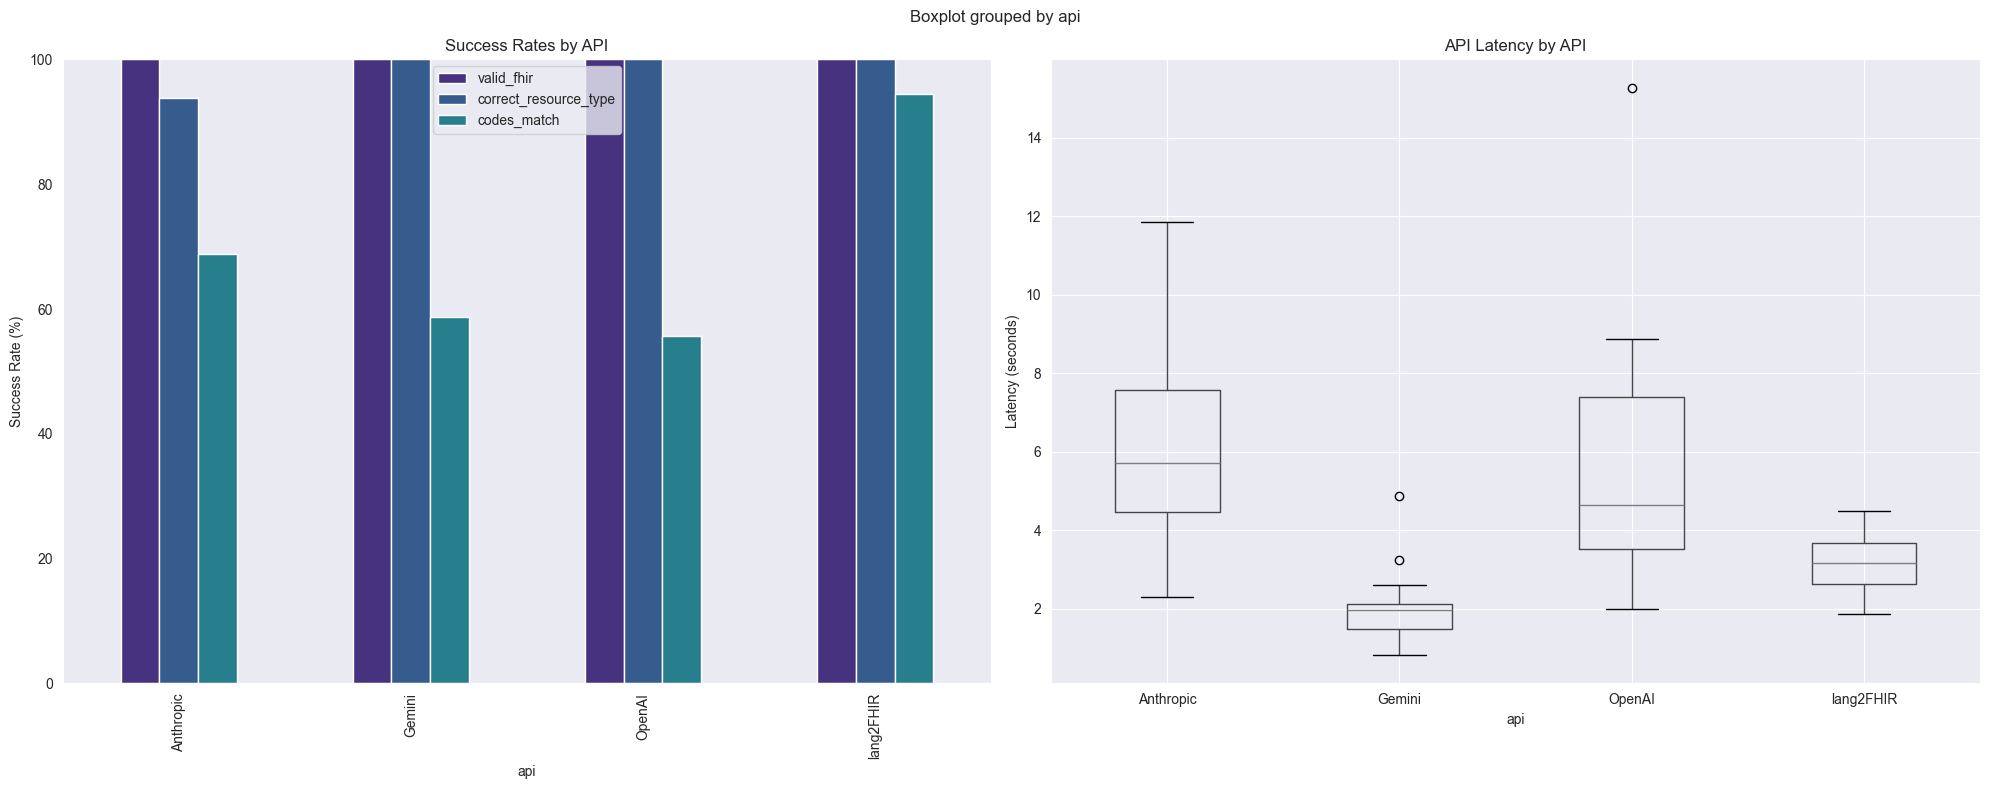

In [ ]:
sns.set_style("dark") 
sns.set_palette("viridis")
fig, axes = plt.subplots(1, 2, figsize=(20, 8))  

# 1. Success Rate by Model
success_metrics = cleaned_benchmark_results_df.groupby('api').agg({
    'valid_fhir': 'mean',
    'correct_resource_type': 'mean',
    'codes_match': 'mean'
}).round(3) * 100

success_metrics.plot(kind='bar', ax=axes[0])
axes[0].set_title('Success Rates by API (N=15)')
axes[0].set_ylabel('Success Rate (%)')
axes[0].set_ylim([0, 100])

# 2. Average Latency by Model
cleaned_benchmark_results_df.boxplot(column='latency', by='api', ax=axes[1])
axes[1].set_title('API Latency by API (N=15)')
axes[1].set_ylabel('Latency (seconds)')

plt.tight_layout()
plt.show()